In [69]:
#130713

# Course Work 1

## Exercise 1

In this exercise, you will implement the EM  algorithms for classification. Please read the instructions in the pdf provided in e-class.

In [70]:
# Here your ID:
import numpy as np
import matplotlib.pyplot as plt #can be reeplaced by other libraries
import scipy.io
import pandas as pd
#is not allowed to use libraries besides the ones here besides reeplacing matplotlib

In [71]:
class GaussianMixtureEM:
    """
    Gaussian Mixture Model using Expectation-Maximization Algorithm
    """

    def __init__(self, n_components=1, max_iter=1000, tol=1e-6, random_state=42, log_file=None):
        """
        Initialize the Gaussian Mixture Model

        Parameters:
        - n_components: number of Gaussian components
        - max_iter: maximum number of iterations
        - tol: convergence tolerance
        - random_state: random seed for reproducibility
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        self.log_file = log_file

        # Model parameters
        self.weights = None
        self.means = None
        self.covariances = None

        # Training history
        self.neg_log_likelihoods = []
        self.converged = False
        self.n_iter = 0

    def _log_message(self, message):
        """Escreve a mensagem no arquivo de log ou imprime no console."""
        if self.log_file:
            self.log_file.write(message + '\n')
        else:
            print(message)


    def _initialize_parameters(self, X):
        """Initialize model parameters"""
        n_samples, n_features = X.shape

        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components

        # Initialize means using k-means++ like approach
        self.means = np.zeros((self.n_components, n_features))

        # Choose first mean randomly
        self.means[0] = X[np.random.randint(n_samples)]

        # Choose remaining means to be far from existing ones
        for i in range(1, self.n_components):
            distances = np.zeros(n_samples)
            for j in range(n_samples):
                min_dist = float('inf')
                for k in range(i):
                    dist = np.linalg.norm(X[j] - self.means[k])
                    min_dist = min(min_dist, dist)
                distances[j] = min_dist

            # Choose next mean with probability proportional to squared distance
            probabilities = distances ** 2
            probabilities /= probabilities.sum()
            cumulative_probs = np.cumsum(probabilities)
            r = np.random.random()
            self.means[i] = X[np.searchsorted(cumulative_probs, r)]

        # Initialize covariances using subset of data as suggested
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        subset_size = max(n_samples // self.n_components, 10)

        for i in range(self.n_components):
            # Use random subset for each component
            subset_indices = np.random.choice(n_samples,
                                            min(subset_size, n_samples),
                                            replace=False)
            subset = X[subset_indices]
            self.covariances[i] = np.cov(subset.T) + 1e-6 * np.eye(n_features)

    def _multivariate_gaussian_pdf(self, X, mean, cov):
        """Compute multivariate Gaussian PDF"""
        n_features = X.shape[1]
        diff = X - mean

        # Add regularization to avoid singular covariance
        cov_reg = cov + 1e-6 * np.eye(n_features)

        try:
            cov_inv = np.linalg.inv(cov_reg)
            det = np.linalg.det(cov_reg)
        except np.linalg.LinAlgError:
            # Fallback to pseudo-inverse if singular
            cov_inv = np.linalg.pinv(cov_reg)
            det = np.linalg.det(cov_reg + 1e-3 * np.eye(n_features))

        if det <= 0:
            det = 1e-10

        norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * det)
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)

        return norm_const * np.exp(exponent)

    def _e_step(self, X):
        """Expectation step"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        # Compute responsibilities
        for k in range(self.n_components):
            responsibilities[:, k] = (self.weights[k] *
                                    self._multivariate_gaussian_pdf(X,
                                                                   self.means[k],
                                                                   self.covariances[k]))

        # Normalize responsibilities
        row_sums = responsibilities.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1e-10  # Avoid division by zero
        responsibilities /= row_sums

        return responsibilities

    def _m_step(self, X, responsibilities):
        """Maximization step"""
        n_samples, n_features = X.shape

        # Update weights
        Nk = responsibilities.sum(axis=0)

        # Prevent weights from becoming too small
        self.weights = np.maximum(Nk / n_samples, 1e-3)
        self.weights /= self.weights.sum()  # Renormalize

        # Update means
        for k in range(self.n_components):
            if Nk[k] > 0:
                self.means[k] = (responsibilities[:, k:k+1].T @ X) / Nk[k]

        # Update covariances
        for k in range(self.n_components):
            if Nk[k] > 1:  # Need at least 2 points for covariance
                diff = X - self.means[k]
                weighted_diff = responsibilities[:, k:k+1] * diff
                cov = (weighted_diff.T @ diff) / Nk[k]

                # Ensure positive definite with stronger regularization
                eigenvals = np.linalg.eigvals(cov)
                min_eigenval = np.min(eigenvals)
                reg_strength = max(1e-4, -min_eigenval + 1e-4)

                self.covariances[k] = cov + reg_strength * np.eye(n_features)
            else:
                # Fallback to identity for very small components
                self.covariances[k] = np.eye(n_features)

    def _compute_log_likelihood(self, X):
        """Compute log-likelihood of the data"""
        n_samples = X.shape[0]
        log_likelihood = 0

        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(self.n_components):
                sample_likelihood += (self.weights[k] *
                                    self._multivariate_gaussian_pdf(X[i:i+1],
                                                                   self.means[k],
                                                                   self.covariances[k])[0])

            if sample_likelihood > 0:
                log_likelihood += np.log(sample_likelihood)

        return log_likelihood

    def fit(self, X, plot_progress=False, plot_every=10):
        """Fit the Gaussian Mixture Model using EM algorithm"""
        self._initialize_parameters(X)

        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self._e_step(X)

            # M-step
            self._m_step(X, responsibilities)

            # Compute log-likelihood
            log_likelihood = self._compute_log_likelihood(X)

            # Check for NaN or infinite values
            if np.isnan(log_likelihood) or np.isinf(log_likelihood):
                print(f"Warning: Invalid log-likelihood at iteration {iteration}. Stopping.")
                break

            self.neg_log_likelihoods.append(-log_likelihood)

            # Plot progress for 2D data
            if plot_progress and X.shape[1] == 2 and iteration % plot_every == 0:
                self._plot_progress(X, iteration)

            # Check convergence
            improvement = log_likelihood - prev_log_likelihood

            if abs(improvement) < self.tol:
                self.converged = True
                self.n_iter = iteration + 1
                if plot_progress and X.shape[1] == 2 and not iteration % plot_every == 0:
                    self._plot_progress(X, iteration)
                self._log_message(f"Converged after {self.n_iter} iterations")
                break

            prev_log_likelihood = log_likelihood

        if not self.converged:
            self.n_iter = self.max_iter
            self._log_message(f"Did not converge after {self.max_iter} iterations")

        return self

    def predict(self, X):
        """Predict the most likely component for each sample"""
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)

    def predict_proba(self, X):
        """Predict component probabilities for each sample"""
        return self._e_step(X)

    def _plot_progress(self, X, iteration):
        """Plot training progress for 2D data with Gaussian contours"""
        plt.figure(figsize=(10, 8))
        plt.scatter(X[:, 0], X[:, 1], alpha=0.6, s=30, c='black', label='Data points')

        colors = ['red', 'blue', 'green', 'orange', 'purple']

        for k in range(self.n_components):
            color = colors[k % len(colors)]

            # Plot mean
            plt.scatter(self.means[k, 0], self.means[k, 1],
                       marker='x', s=200, linewidths=3,
                       color=color, label=f'Mean {k+1}')

            # Plot Gaussian contours (1 std and 2 std)
            self._plot_gaussian_contours(self.means[k], self.covariances[k], color)

        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f'EM Algorithm Progress - Iteration {iteration}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.show()

    def _plot_gaussian_contours(self, mean, cov, color):
        """Plot Gaussian contours at 1 and 2 standard deviations"""
        # Generate points for ellipse
        theta = np.linspace(0, 2 * np.pi, 100)

        # Get eigenvalues and eigenvectors
        eigenvals, eigenvecs = np.linalg.eigh(cov)

        # Sort by eigenvalue
        order = eigenvals.argsort()[::-1]
        eigenvals = eigenvals[order]
        eigenvecs = eigenvecs[:, order]

        # Calculate ellipse parameters
        angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))

        # Plot 1 std and 2 std contours
        for n_std in [1, 2]:
            width = 2 * n_std * np.sqrt(eigenvals[0])
            height = 2 * n_std * np.sqrt(eigenvals[1])

            # Parametric ellipse
            ellipse_x = (width/2) * np.cos(theta)
            ellipse_y = (height/2) * np.sin(theta)

            # Rotate ellipse
            cos_angle = np.cos(np.radians(angle))
            sin_angle = np.sin(np.radians(angle))

            x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
            y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle

            # Translate to mean
            x_final = x_rot + mean[0]
            y_final = y_rot + mean[1]

            # Plot with different alpha for different std levels
            alpha = 0.3 if n_std == 1 else 0.15
            plt.fill(x_final, y_final, color=color, alpha=alpha,
                    label=f'{n_std}σ' if n_std == 1 else f'{n_std}σ')
            plt.plot(x_final, y_final, color=color, linewidth=1.5, alpha=0.8)

    def plot_log_likelihood(self):
        """Plot log-likelihood over iterations"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.neg_log_likelihoods, 'b-', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Log-Likelihood')
        plt.title('Log-Likelihood During Training')
        plt.grid(True, alpha=0.3)
        plt.show()

In [72]:
class GaussianMixtureClassifier:
    """
    Classifier using Gaussian Mixture Models for each class
    """

    def __init__(self, n_components_per_class=2, max_iter=50, log_file=None, **gmm_params):
        """
        Initialize the classifier

        Parameters:
        - n_components_per_class: int or dict
            - If int: same number of components for all classes
            - If dict: {class_label: n_components} for different components per class
        - max_iter: maximum number of iterations for GMMs
        - gmm_params: additional parameters for GaussianMixtureEM
        """
        self.n_components_per_class = n_components_per_class
        self.max_iter = max_iter
        self.gmm_params = gmm_params
        self.class_models = {}
        self.classes = None
        self.log_file = log_file

    def _log_message(self, message):
        """Escreve a mensagem no arquivo de log ou imprime no console."""
        if self.log_file:
            self.log_file.write(message + '\n')
        else:
            print(message)

    def fit(self, X, y, plot_progress=False):
        """Fit a GMM for each class"""
        self.classes = np.unique(y)

        for class_label in self.classes:
            self._log_message(f"\nTreinando GMM para classe {class_label}...")
            class_data = X[y == class_label]

            # Determine number of components for this class
            if isinstance(self.n_components_per_class, dict):
                n_comp = self.n_components_per_class.get(class_label, 1)
            else:
                n_comp = self.n_components_per_class

            self._log_message(f"Usando {n_comp} componentes para classe {class_label}")

            gmm = GaussianMixtureEM(
                n_components=n_comp,
                max_iter=self.max_iter,
                log_file=self.log_file,
                **self.gmm_params
            )

            gmm.fit(class_data, plot_progress=plot_progress)
            self.class_models[class_label] = gmm

        return self

    def predict(self, X):
        """Predict class labels"""
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)

        for i in range(n_samples):
            max_likelihood = -np.inf
            best_class = self.classes[0]

            for class_label in self.classes:
                gmm = self.class_models[class_label]
                likelihood = gmm._compute_log_likelihood(X[i:i+1])

                if likelihood > max_likelihood:
                    max_likelihood = likelihood
                    best_class = class_label

            predictions[i] = best_class

        return predictions.astype(int)

    def plot_all_log_likelihoods(self):
        """Plot log-likelihood curves for all classes"""
        plt.figure(figsize=(12, 8))

        for class_label in self.classes:
            gmm = self.class_models[class_label]
            plt.plot(gmm.neg_log_likelihoods,
                    linewidth=2,
                    label=f'Classe {class_label}')

        plt.xlabel('Iteração')
        plt.ylabel('Log-Likelihood')
        plt.title('Log-Likelihood Durante o Treinamento para Todas as Classes')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

In [73]:
def train_test_split(X, y, test_size=0.2, random_state=None, stratify=None):
    """Simple train-test split implementation"""
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = len(X)
    n_test = int(n_samples * test_size)

    if stratify is not None:
        # Stratified split
        unique_classes = np.unique(stratify)
        train_indices = []
        test_indices = []

        for class_label in unique_classes:
            class_indices = np.where(stratify == class_label)[0]
            n_class_test = int(len(class_indices) * test_size)

            np.random.shuffle(class_indices)
            test_indices.extend(class_indices[:n_class_test])
            train_indices.extend(class_indices[n_class_test:])

        train_indices = np.array(train_indices)
        test_indices = np.array(test_indices)
    else:
        # Random split
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        test_indices = indices[:n_test]
        train_indices = indices[n_test:]

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


def accuracy_score(y_true, y_pred):
    """Calculate accuracy score"""
    return np.mean(y_true == y_pred)


def precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0):
    """Calculate precision, recall, f1-score and support"""
    classes = np.unique(y_true)
    n_classes = len(classes)

    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1 = np.zeros(n_classes)
    support = np.zeros(n_classes)

    for i, class_label in enumerate(classes):
        # True positives, false positives, false negatives
        tp = np.sum((y_true == class_label) & (y_pred == class_label))
        fp = np.sum((y_true != class_label) & (y_pred == class_label))
        fn = np.sum((y_true == class_label) & (y_pred != class_label))

        # Precision
        if tp + fp == 0:
            precision[i] = zero_division
        else:
            precision[i] = tp / (tp + fp)

        # Recall
        if tp + fn == 0:
            recall[i] = zero_division
        else:
            recall[i] = tp / (tp + fn)

        # F1-score
        if precision[i] + recall[i] == 0:
            f1[i] = zero_division
        else:
            f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

        # Support
        support[i] = np.sum(y_true == class_label)

    return precision, recall, f1, support.astype(int)

def evaluate_model(y_true, y_pred, class_names=None):
    """Evaluate model performance"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    print(f"\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nPer-class metrics:")

    classes = np.unique(y_true)
    for i, class_label in enumerate(classes):
        class_name = f"Class {class_label}" if class_names is None else class_names[i]
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-score: {f1[i]:.4f}")
        print(f"  Support: {support[i]}")

    return accuracy, precision, recall, f1

def hyperparameter_tuning(X_train, y_train, X_val, y_val, n_components_options, max_iter=50, log_file=None):
    """
    Tune hyperparameters using validation set

    Parameters:
    - n_components_options: list of possible number of components for each class
        e.g. [1, 2, 3] to test different combinations for each class
    - max_iter: maximum number of iterations for GMM
    """
    from itertools import product
    import numpy as np

    classes = np.unique(y_train)
    n_classes = len(classes)

    # Generate all possible combinations of components for each class
    all_combinations = list(product(n_components_options, repeat=n_classes))
    all_configs = []

    # Convert combinations to dictionary format
    for combo in all_combinations:
        config = {classes[i]: combo[i] for i in range(n_classes)}
        all_configs.append(config)

    best_score = -1
    best_config = all_configs[0]

    print(f"Testando {len(all_configs)} combinações de componentes...")
    if log_file:
        log_file.write(f"Testando {len(all_configs)} combinações de componentes...")

    for config in all_configs:
        config_str = ", ".join([f"Classe {c}: {n} componentes" for c, n in config.items()])
        print(f"\nTestando configuração: {config_str}")
        if log_file:
            log_file.write(f"\nTestando configuração: {config_str}")


        classifier = GaussianMixtureClassifier(
            n_components_per_class=config,
            max_iter=max_iter,
            tol=1e-6,
            random_state=42,
            log_file=log_file
        )

        try:
            classifier.fit(X_train, y_train)
            y_val_pred = classifier.predict(X_val)
            score = accuracy_score(y_val, y_val_pred)

            print(f"Acurácia de validação: {score:.4f}")

            if score > best_score:
                best_score = score
                best_config = config
        except Exception as e:
            print(f"Erro com configuração {config_str}: {e}")
            continue

    print(f"\nMelhor configuração: {best_config}")
    print(f"Melhor acurácia de validação: {best_score:.4f}")

    return best_config

In [74]:
print("PARTE 1: Classificação de Dados 2D")
print("="*50)

# Carrega os dados
data = scipy.io.loadmat('exercise1_2.mat')
C0 = data['C0']
C1 = data['C1']

X = np.vstack([C0, C1])
y = np.hstack([np.zeros(len(C0)), np.ones(len(C1))])

# Divide
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de validação: {len(X_val)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

# Hyperparametros
component_options = [1, 2, 3]
max_iterations = 50

log_file = open('gmm_parte1.log', 'w')

# Encontra a melhor configuração
best_config = hyperparameter_tuning(
    X_train, y_train, X_val, y_val, component_options, max_iter=max_iterations, log_file=log_file
)

log_file.close()

PARTE 1: Classificação de Dados 2D
Tamanho do conjunto de treinamento: 10800
Tamanho do conjunto de validação: 2700
Tamanho do conjunto de teste: 1500
Testando 9 combinações de componentes...

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 1 componentes
Acurácia de validação: 0.9811

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 2 componentes
Acurácia de validação: 0.9878

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 3 componentes
Acurácia de validação: 0.9881

Testando configuração: Classe 0.0: 2 componentes, Classe 1.0: 1 componentes
Acurácia de validação: 0.9781

Testando configuração: Classe 0.0: 2 componentes, Classe 1.0: 2 componentes
Acurácia de validação: 0.9911

Testando configuração: Classe 0.0: 2 componentes, Classe 1.0: 3 componentes
Acurácia de validação: 0.9915

Testando configuração: Classe 0.0: 3 componentes, Classe 1.0: 1 componentes
Acurácia de validação: 0.9785

Testando configuração: Classe 0.0: 3 componentes, Classe 1


Treinando modelo final com configuração: {np.float64(0.0): 2, np.float64(1.0): 3}


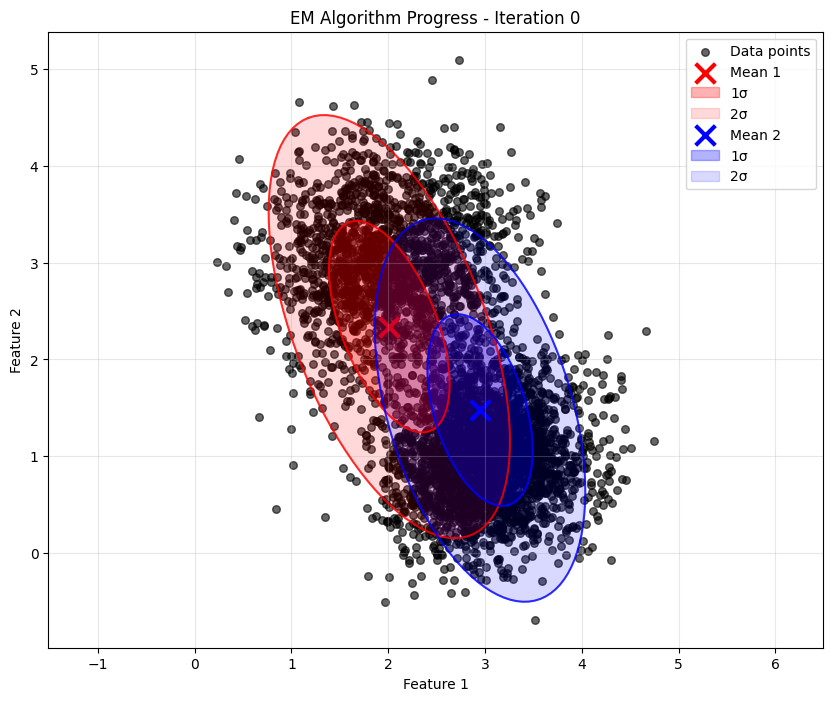

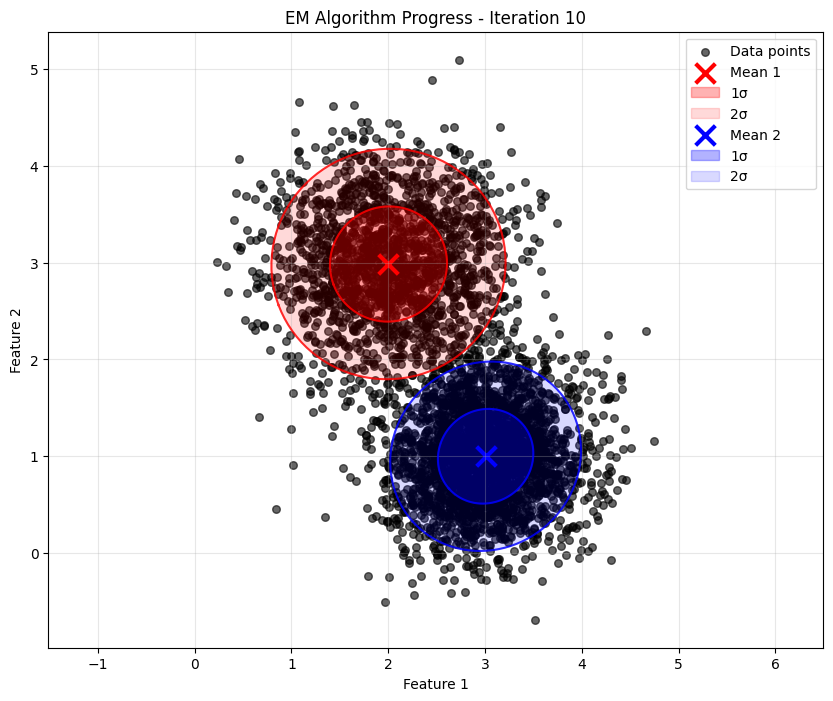

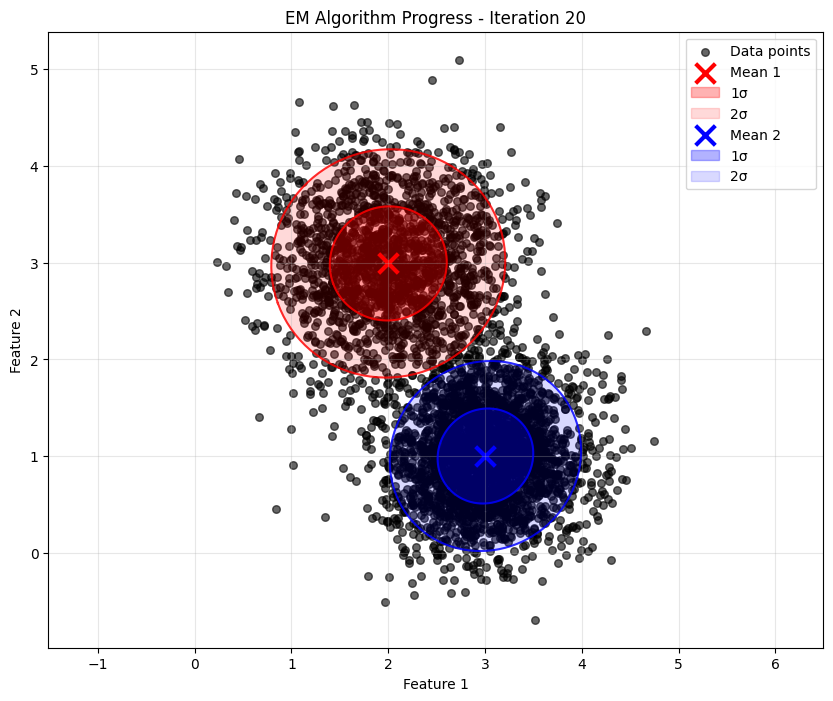

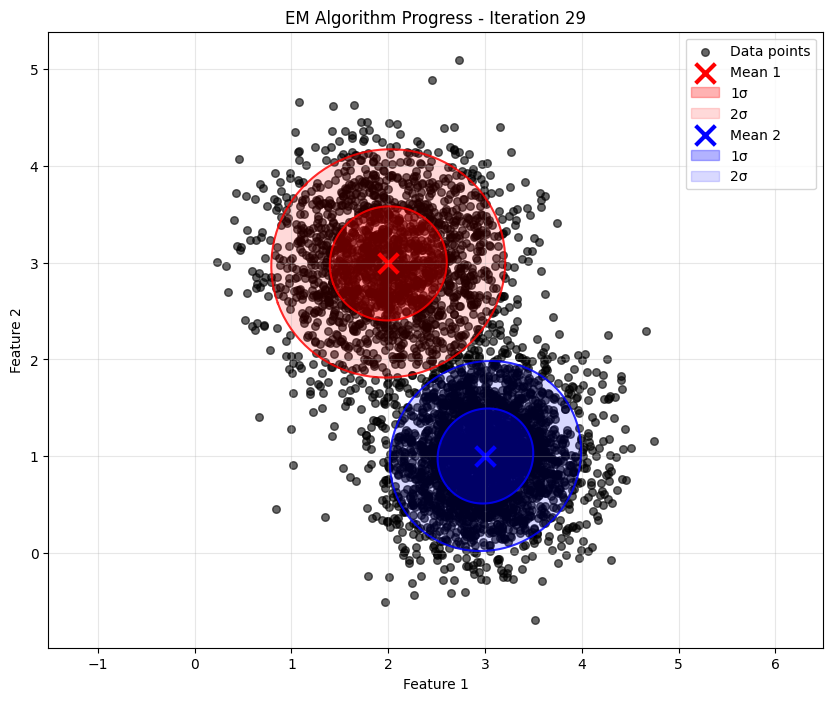

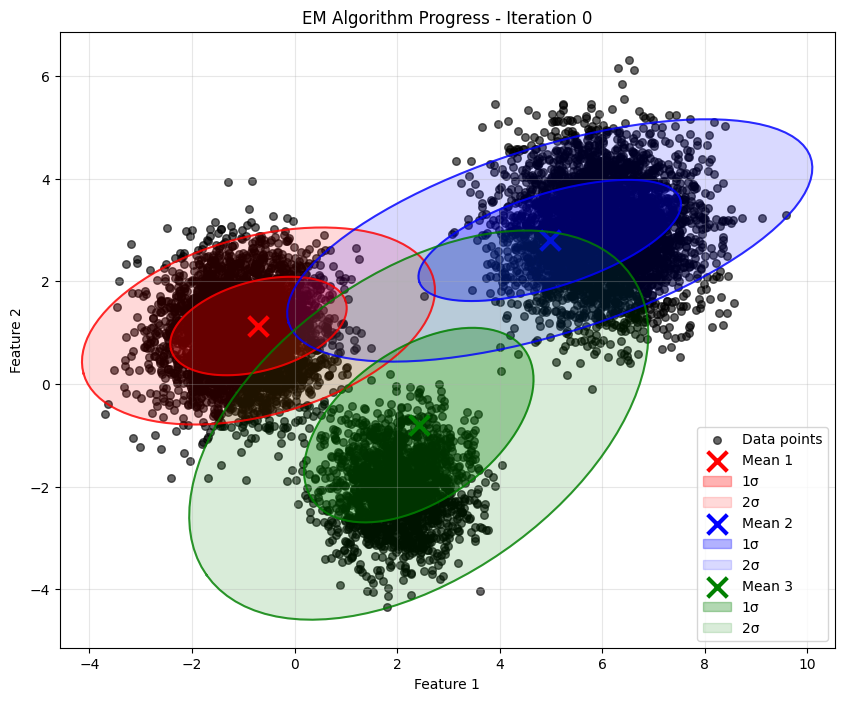

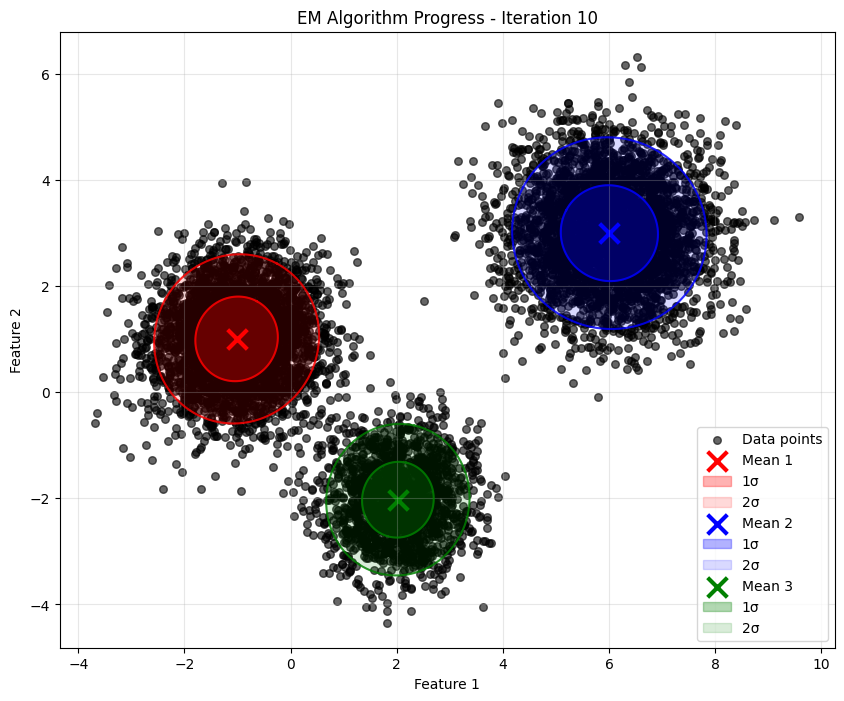

In [75]:
# Treina o modelo final
log_file = open('gmm_parte1.log', 'a')

print(f"\nTreinando modelo final com configuração: {best_config}")
classifier = GaussianMixtureClassifier(
    n_components_per_class=best_config,
    max_iter=50,
    tol=1e-6,
    random_state=42,
    log_file=log_file
)

X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])

classifier.fit(X_train_val, y_train_val, plot_progress=True)

# Previsões de teste
y_pred = classifier.predict(X_test)

log_file.close()

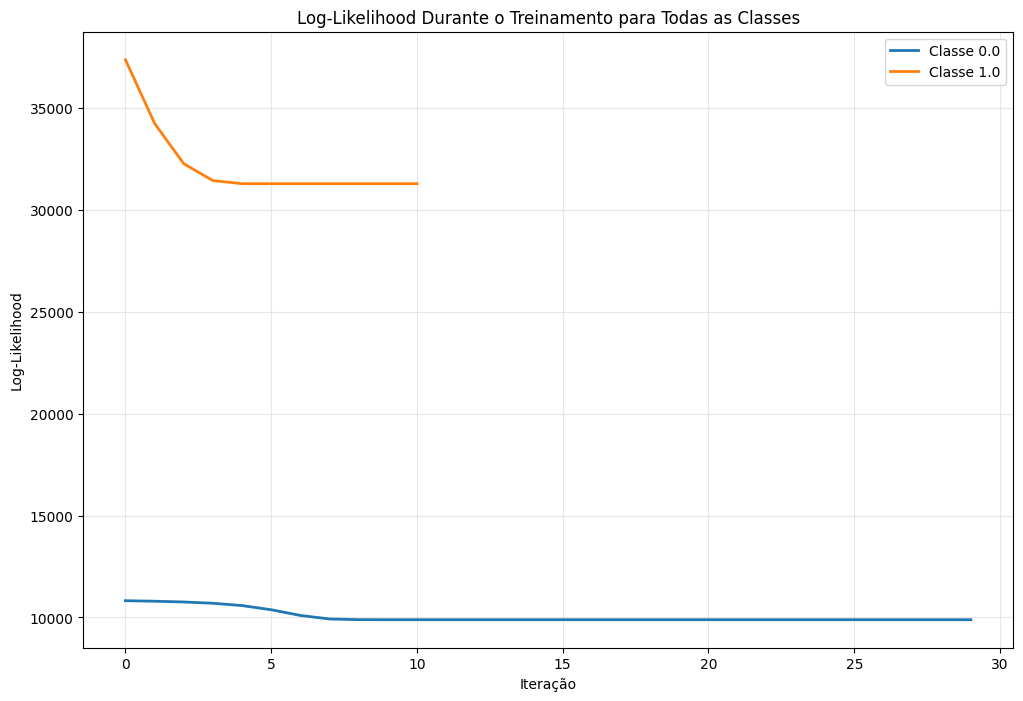

In [76]:
classifier.plot_all_log_likelihoods()

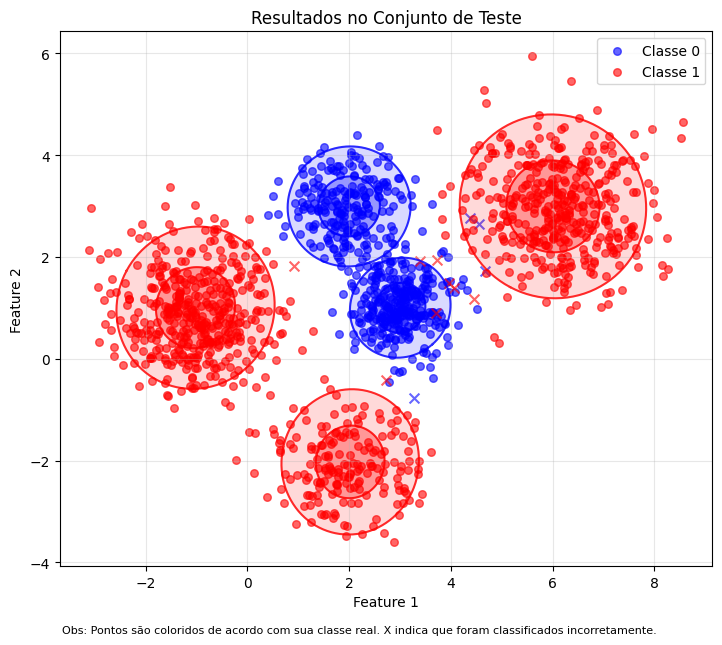

In [77]:
plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
colors_train = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']

for i, class_label in enumerate(classifier.classes):
    # Separar dados corretos e incorretos para esta classe
    mask_true = (y_test == class_label)
    mask_correct = (y_test == class_label) & (y_pred == class_label)
    mask_incorrect = (y_test == class_label) & (y_pred != class_label)

    # Plota previsões corretas com círculos
    ax1.scatter(X_test[mask_correct, 0], X_test[mask_correct, 1],
                c=colors_train[i % len(colors_train)], alpha=0.6, s=30,
                marker='o', label=f'Classe {int(class_label)}')

    # Plota previsões incorretas com X
    ax1.scatter(X_test[mask_incorrect, 0], X_test[mask_incorrect, 1],
                c=colors_train[i % len(colors_train)], alpha=0.6, s=50,
                marker='x')

    # Plota círculos de desvio padrão para cada componente da classe
    gmm = classifier.class_models[class_label]
    for comp in range(len(gmm.means)):
        mean = gmm.means[comp]
        cov = gmm.covariances[comp]

        eigenvals, eigenvecs = np.linalg.eigh(cov)

        theta = np.linspace(0, 2*np.pi, 100)

        for n_std in [1, 2]:
            circle = np.array([
                np.cos(theta),
                np.sin(theta)
            ])

            circle = np.dot(eigenvecs, np.sqrt(eigenvals[:, np.newaxis]) * circle)
            circle = n_std * circle + mean[:, np.newaxis]

            color = colors_train[i % len(colors_train)]
            x_final = circle[0]
            y_final = circle[1]

            alpha = 0.3 if n_std == 1 else 0.15
            plt.fill(x_final, y_final, color=color, alpha=alpha)
            plt.plot(x_final, y_final, color=color, linewidth=1.5, alpha=0.8)

ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Resultados no Conjunto de Teste')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')

# Adiciona texto explicativo abaixo do gráfico
plt.figtext(0.26, -0.04,
            'Obs: Pontos são coloridos de acordo com sua classe real. X indica que foram classificados incorretamente.',
            ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()


In [78]:
print("\n\nPARTE 2: Classificação de Dados 5D")
print("="*50)

# Carrega os dados
data = scipy.io.loadmat('exercise1_5.mat')
C0 = data['C0']
C1 = data['C1']
C2 = data['C2']

X = np.vstack([C0, C1, C2])
y = np.hstack([
    np.zeros(len(C0)),
    np.ones(len(C1)),
    np.full(len(C2), 2)
])

# Divide os dados
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de validação: {len(X_val)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

# Hyperparametros
component_options = [1, 2, 3]
max_iterations = 50

log_file = open('gmm_parte2.log', 'w')

# Encontrar a melhor configuração
best_config_2 = hyperparameter_tuning(
    X_train, y_train, X_val, y_val, component_options, max_iter=max_iterations, log_file=log_file
)

log_file.close()




PARTE 2: Classificação de Dados 5D
Tamanho do conjunto de treinamento: 68400
Tamanho do conjunto de validação: 17100
Tamanho do conjunto de teste: 9500
Testando 27 combinações de componentes...

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 1 componentes, Classe 2.0: 1 componentes
Acurácia de validação: 0.9081

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 1 componentes, Classe 2.0: 2 componentes
Acurácia de validação: 0.9036

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 1 componentes, Classe 2.0: 3 componentes
Acurácia de validação: 0.9292

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 2 componentes, Classe 2.0: 1 componentes
Acurácia de validação: 0.9227

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 2 componentes, Classe 2.0: 2 componentes
Acurácia de validação: 0.9132

Testando configuração: Classe 0.0: 1 componentes, Classe 1.0: 2 componentes, Classe 2.0: 3 componentes
Acurácia de validação: 0.9390



Treinando modelo final com configuração: {np.float64(0.0): 3, np.float64(1.0): 3, np.float64(2.0): 3}


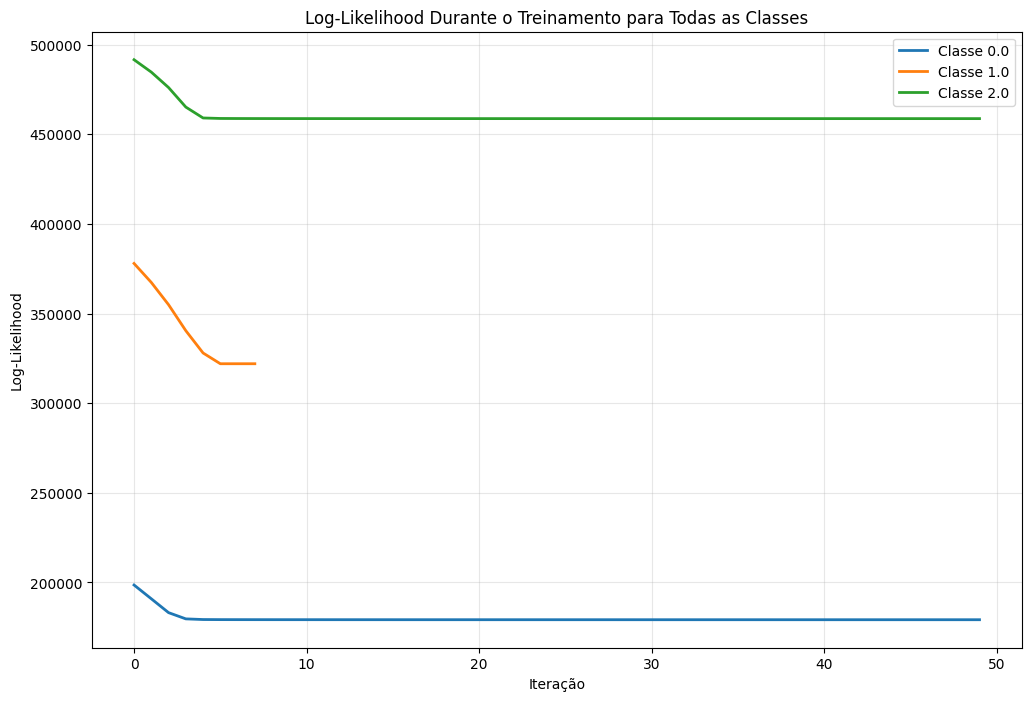

In [79]:
# Treina o modelo final
log_file = open('gmm_parte2.log', 'a')

print(f"\nTreinando modelo final com configuração: {best_config_2}")
classifier = GaussianMixtureClassifier(
    n_components_per_class=best_config_2,
    max_iter=50,
    tol=1e-6,
    random_state=42,
    log_file=log_file
)

X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])

classifier.fit(X_train_val, y_train_val)

log_file.close()

# Mostra curvas de log-likelihood
classifier.plot_all_log_likelihoods()


In [80]:
# Evaluate
y_pred = classifier.predict(X_test)
metrics = evaluate_model(y_test, y_pred, ['Classe 0', 'Classe 1', 'Classe 2'])


Model Evaluation:
Accuracy: 0.9426

Per-class metrics:
Classe 0:
  Precision: 0.8065
  Recall: 0.9630
  F1-score: 0.8778
  Support: 2000
Classe 1:
  Precision: 0.9937
  Recall: 0.9953
  F1-score: 0.9945
  Support: 3000
Classe 2:
  Precision: 0.9844
  Recall: 0.8984
  F1-score: 0.9395
  Support: 4500
